# Keyword Spotting
This project uses RNN model with Attention layer to train our dataset (Google Speech Commands version 2)

In [2]:
# imports

%load_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import DBDownloader
import Generator
import Models
import audioTools

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import Model

import librosa

from sklearn.metrics import confusion_matrix

In [5]:
# Setting up the data
gscInfo, nCategs = DBDownloader.SetUpGoogleSpeechCmd()

TensorShape([2, 125, 513])

We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

# Speech Data Generator

To allocate the data dynamically we use Keras Generator

In [8]:
sr = 16000 
iLen = 16000
trainGen, valGen, testGen, testRGen = Generator.setUpDB(gscInfo)

311

# The Model

In [23]:
model = Models.createModel(nCategs, sr)
# model.load_weights('attRNN-weights.h5')
model, results = Models.trainAndSave(nCategs, sr, trainGen, valGen, model)

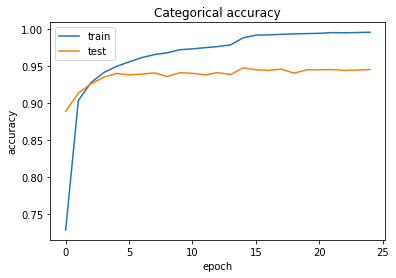

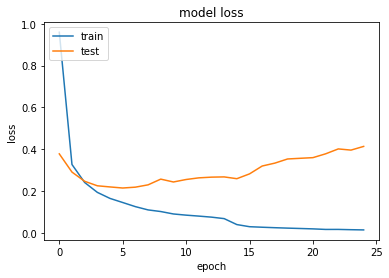

In [25]:
audioTools.plotCatAcc(results)
audioTools.plotLoss(results)

In [30]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.030799511820077896, 0.9913240075111389] 
Validation: [0.25848108530044556, 0.9480506181716919] 
Test: [0.2578895092010498, 0.9421172142028809]


## Evaluation and Plots

In [32]:
attSpeechModel = Model(inputs=model.input, outputs=[model.get_layer('output').output, model.get_layer('attSoftmax').output, model.get_layer('tf.expand_dims').output])

audios, classes = valGen.__getitem__(3)

outs, attW, specs = attSpeechModel.predict(audios)

np.argmax(outs,axis=1)

imgHeight = 2
idAudio = 8

y_pred = model.predict(x_test, verbose=1)
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

audioTools.plotRawWav(audios[idAudio], imgHeight)

audioTools.plotAttW(attW[idAudio], imgHeight)

audioTools.plotSpecVis(specs[idAudio,:,:,0].T, imgHeight)

audioTools.plotConfusionMatrix(cm, classes, normalize=False)

# Save the model

In [47]:
model_16000 = Models.AttRNNModel(nCategs, samplingrate = sr, inputLength = None)
model_16000.load_weights('attRNN-weights.h5')

tf.saved_model.save(model_16000, 'KWS-attRNN')

# model_16000 = tf.saved_model.load('KWS-attRNN')

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('KWS-attRNN') # path to the SavedModel directory

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the model.
with open('KWS-attRNN.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: model-KWS-attRNN/assets


INFO:tensorflow:Assets written to: model-KWS-attRNN/assets
